<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-и-цель-работы" data-toc-modified-id="Описание-и-цель-работы-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание и цель работы</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Модель-бустинга-(CatBoostRegressor)" data-toc-modified-id="Модель-бустинга-(CatBoostRegressor)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель бустинга (CatBoostRegressor)</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-обучению-моделей:" data-toc-modified-id="Вывод-по-обучению-моделей:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод по обучению моделей:</a></span></li></ul></li><li><span><a href="#Общий-вывод-по-работе" data-toc-modified-id="Общий-вывод-по-работе-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по работе</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных-и-признаки" data-toc-modified-id="Анализ-данных-и-признаки-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анализ данных и признаки</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

### Описание и цель работы
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


In [22]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

## Подготовка данных

In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
    
taxi = taxi.sort_index()

In [3]:
# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.tail())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())

In [4]:
data_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков в датафрейме:  num_orders    0
dtype: int64


### Промежуточный вывод

Данные выглядят нормально, пропусков нет. Аномальных значений нет, медиана и среднее практически равны. Дубликаты удалять не следует, так как удалится почти весь массив данных + для каждой строки мы имеем уникальный datetime поле.

In [5]:
# выполним ресемплирование по часу, суммируя количество заказов
taxi_resampled = taxi.resample('1H').sum()
data_info(taxi_resampled)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Пропусков в датафрейме:  num_orders    0
dtype: int64


In [7]:
# лаги перемещены в функцию, после ревью удалю это ячейку
# сейчас оставил, потому что иначе мы запутаемся что куда)

## EDA

Напишем визуализацию временного ряда, проведем декомпозицию и сделаем анализ автокорелляции

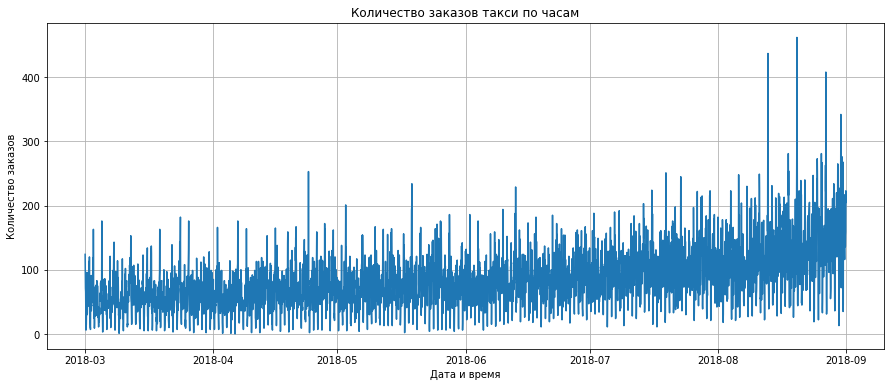

In [8]:
# Визуализация временного ряда
plt.figure(figsize=(15, 6))
plt.plot(taxi_resampled.index, taxi_resampled['num_orders'])
plt.title('Количество заказов такси по часам')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()


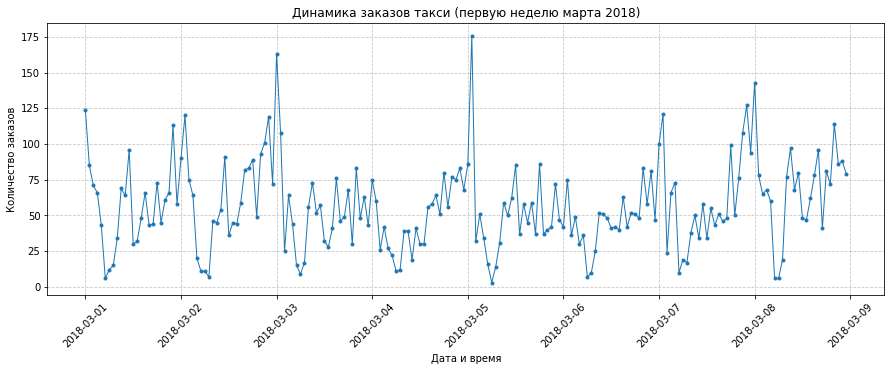

In [9]:
# ничего не разобрать, сделаем срез
# Выбираем период для наглядности
sample_data = taxi_resampled.loc['2018-03-01':'2018-03-08']

plt.figure(figsize=(15, 5))
plt.plot(sample_data.index, sample_data['num_orders'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Динамика заказов такси (первую неделю марта 2018)')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

На получившемся графике четко видно возрастание количества заказов к вечеру-ночи и минимуму заказов утром. Также выделяются 2 пика со 2 на 3 марта, это вечер перед выходными. В выходные заказов меньше, а вечер воскресенья, наоборот, собирает пик заказов. Для убедительности выводов, построим такой же срез, но на период первой недели августа 2018 года.

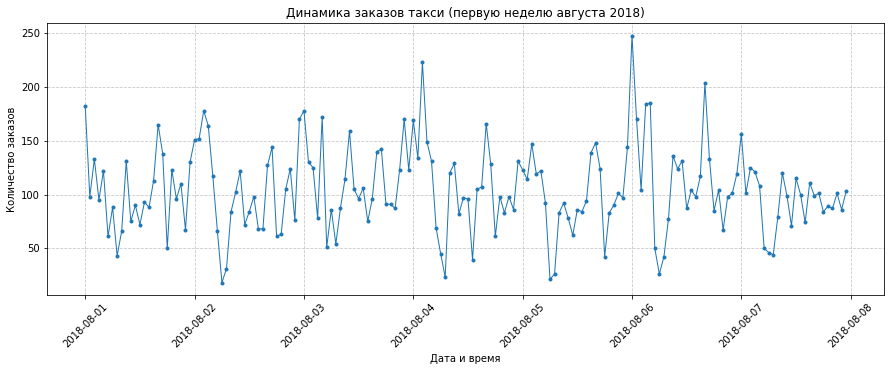

In [10]:
sample_data = taxi_resampled.loc['2018-08-01':'2018-08-07']

plt.figure(figsize=(15, 5))
plt.plot(sample_data.index, sample_data['num_orders'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Динамика заказов такси (первую неделю августа 2018)')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Выводы подтвердились, также наблюдаются вечерние пики заказов. Теперь исследуем данные на сезонность

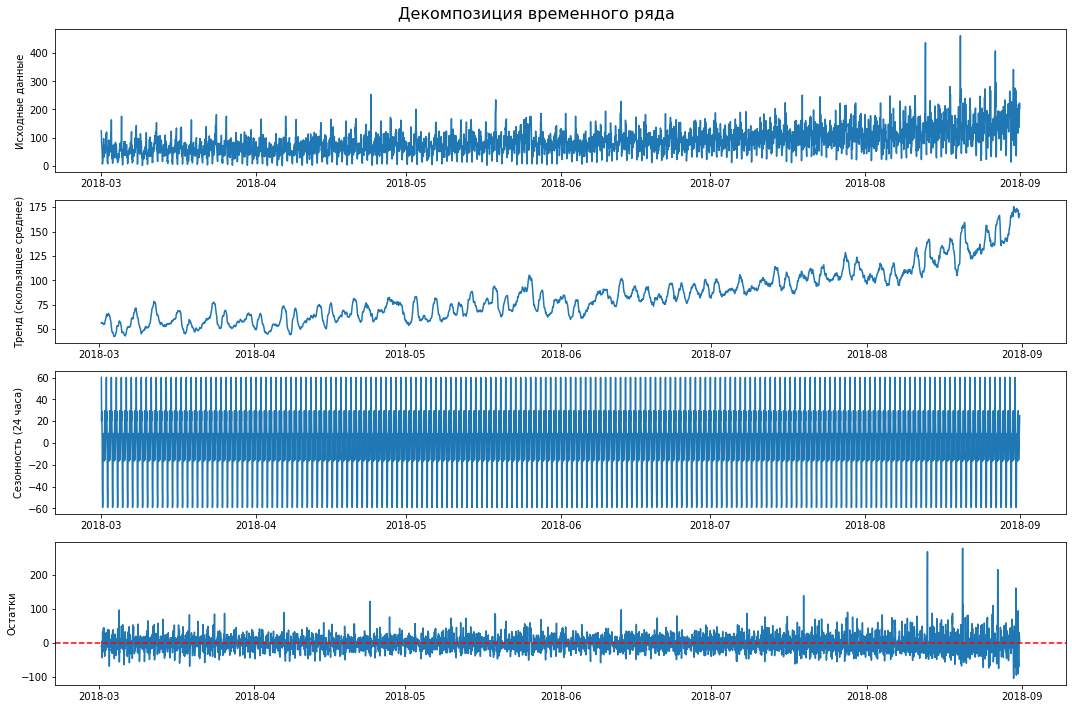

In [11]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(taxi_resampled['num_orders'], period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Декомпозиция временного ряда', fontsize=16)

# Исходный ряд
ax1.plot(decomposition.observed)
ax1.set_ylabel('Исходные данные')

# Тренд
ax2.plot(decomposition.trend)
ax2.set_ylabel('Тренд (скользящее среднее)')

# Сезонность
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Сезонность (24 часа)')

# Остатки
ax4.plot(decomposition.resid)
ax4.set_ylabel('Остатки')
ax4.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()



Тренд: возрастание скользящего среднего в течение полугода.

График сезонности нужно уточнить, построим распределение по часам и заодно посмотрим, как отличается количество заказов в будни и выходные.

График остатков выглядит симметрично относительно 0, но к концу лета появляются аномальные значения.

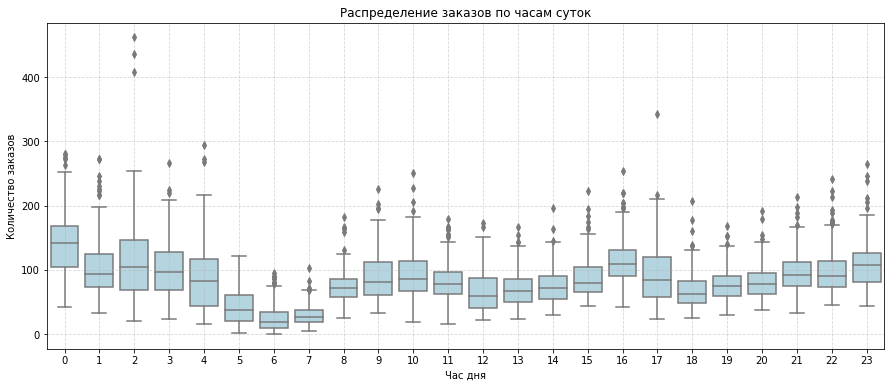

In [12]:
# Добавляем столбец с часом
taxi_resampled['hour'] = taxi_resampled.index.hour

# Боксплот по часам
plt.figure(figsize=(15, 6))
sns.boxplot(data=taxi_resampled, x='hour', y='num_orders', color='lightblue')
plt.title('Распределение заказов по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

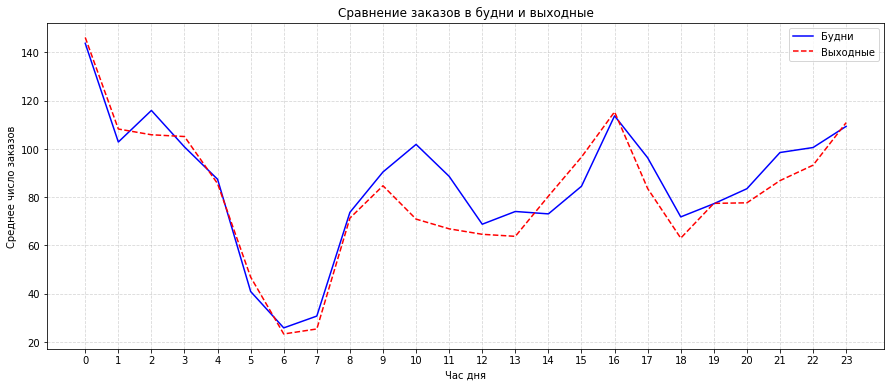

In [13]:
taxi_resampled['dayofweek'] = taxi_resampled.index.dayofweek  # 0-пн, 6-вс
taxi_resampled['is_weekend'] = taxi_resampled['dayofweek'] >= 5  # 5 и 6 – сб и вс

# График для будней и выходных
plt.figure(figsize=(15, 6))

# Будни
weekday_avg = taxi_resampled[taxi_resampled['is_weekend'] == False].groupby('hour')['num_orders'].mean()
weekday_avg.plot(label='Будни', linestyle='-', color='blue')

# Выходные
weekend_avg = taxi_resampled[taxi_resampled['is_weekend'] == True].groupby('hour')['num_orders'].mean()
weekend_avg.plot(label='Выходные', linestyle='--', color='red')

plt.title('Сравнение заказов в будни и выходные')
plt.xlabel('Час дня')
plt.ylabel('Среднее число заказов')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

В будни в середине дня и в целом в течение суток заказов в среднем больше, чем в выходные.

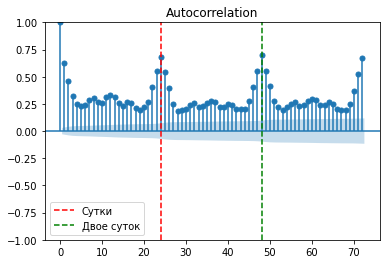

In [14]:
# пронализируем отстающие значения
plot_acf(taxi_resampled['num_orders'], lags=72, alpha=0.05)  # 72 часа = 3 суток
plt.axvline(24, color='red', linestyle='--', label='Сутки')
plt.axvline(48, color='green', linestyle='--', label='Двое суток')
plt.legend()
plt.show()

На 24 и 48 часах видим пики, это означает, что есть сильная связь с данными сутки назад. Поэтому добавим лаг в таблицу. Теперь датасет выглядит так:

In [15]:
def make_features(df, max_lag=24, rolling_mean_size=3):
    data = df.copy()
    
    # Календарные признаки (уровень "ниже" сезонностей)
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # Лаги (1, 2, ..., max_lag)
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    # Написал отдельно, если лагов меньше 168
    data['lag_168'] = data['num_orders'].shift(168)
    
    # Скользящее среднее (сглаживание)
    data['rolling_mean'] = (
        data['num_orders']
        .shift()  # избегаем утечки будущего
        .rolling(rolling_mean_size)
        .mean()
    )
    
    return data

In [16]:
data = make_features(taxi_resampled)
data = data.dropna() 

In [17]:
# is_weekend избыточный признак
data = data.drop('is_weekend', axis = 1)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   hour          4248 non-null   int64  
 2   dayofweek     4248 non-null   int64  
 3   lag_1         4248 non-null   float64
 4   lag_2         4248 non-null   float64
 5   lag_3         4248 non-null   float64
 6   lag_4         4248 non-null   float64
 7   lag_5         4248 non-null   float64
 8   lag_6         4248 non-null   float64
 9   lag_7         4248 non-null   float64
 10  lag_8         4248 non-null   float64
 11  lag_9         4248 non-null   float64
 12  lag_10        4248 non-null   float64
 13  lag_11        4248 non-null   float64
 14  lag_12        4248 non-null   float64
 15  lag_13        4248 non-null   float64
 16  lag_14        4248 non-null   float64
 17  lag_15        4248 non-null

## Обучение

Попробуем обучить три модели: Ridge Regression, Random Forest, CatBoostRegressor.

In [18]:
#разделим данные на тренировочную и тестовую выборки не перемешивая
X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

### Ridge Regression

In [20]:
# Параметры для GridSearchCV
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

tscv = TimeSeriesSplit(n_splits=3)
# Поиск лучшего alpha
ridge = Ridge()
ridge_grid = GridSearchCV(
    ridge,
    ridge_params,
    cv=tscv,  # Используем TimeSeriesSplit
    scoring='neg_root_mean_squared_error'
)
ridge_grid.fit(X_train, y_train)  # Масштабирование не применяем

print(f"Лучший alpha: {ridge_grid.best_params_}")

# Средний RMSE на кросс-валидации
cv_rmse = (-ridge_grid.cv_results_['mean_test_score']).min()
print(f"RMSE на кросс-валидации: {cv_rmse:.2f}")

Лучший alpha: {'alpha': 100}
RMSE на кросс-валидации: 23.78


### Random Forest

In [21]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=3)

# Поиск лучших параметров
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)
rf_grid.fit(X_train, y_train)

print(f"Лучшие параметры Random Forest: {rf_grid.best_params_}")
print(f"RMSE на кросс-валидации: {-rf_grid.best_score_:.2f}")

Лучшие параметры Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
RMSE на кросс-валидации: 24.14


### Модель бустинга (CatBoostRegressor)

In [23]:
# Создаём Pool для CatBoost
train_pool = Pool(X_train, y_train)

catboost_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8]
}

# Кросс-валидация CatBoost (встроенная)
cv_results = CatBoostRegressor(random_state=42).grid_search(
    catboost_params,
    train_pool,
    cv=tscv,
    verbose=False
)

# Лучшая модель
best_cat = CatBoostRegressor(**cv_results['params'], random_state=42, verbose=False)
best_cat.fit(X_train, y_train)
print(f"Лучшие параметры CatBoost: {cv_results['params']}")

0:	learn: 79.6334728	test: 114.9979553	best: 114.9979553 (0)	total: 49.8ms	remaining: 4.93s
1:	learn: 78.9600624	test: 114.2112066	best: 114.2112066 (1)	total: 52.6ms	remaining: 2.58s
2:	learn: 78.2572209	test: 113.3106245	best: 113.3106245 (2)	total: 55.1ms	remaining: 1.78s
3:	learn: 77.5730589	test: 112.5383539	best: 112.5383539 (3)	total: 57.4ms	remaining: 1.38s
4:	learn: 76.9009790	test: 111.7682511	best: 111.7682511 (4)	total: 60ms	remaining: 1.14s
5:	learn: 76.2320929	test: 110.9919906	best: 110.9919906 (5)	total: 62.4ms	remaining: 978ms
6:	learn: 75.5580159	test: 110.1911910	best: 110.1911910 (6)	total: 64.8ms	remaining: 861ms
7:	learn: 74.9046962	test: 109.5010323	best: 109.5010323 (7)	total: 67.2ms	remaining: 772ms
8:	learn: 74.2582139	test: 108.7124258	best: 108.7124258 (8)	total: 69.7ms	remaining: 704ms
9:	learn: 73.6159367	test: 107.9481695	best: 107.9481695 (9)	total: 72.4ms	remaining: 651ms
10:	learn: 72.9834179	test: 107.2426571	best: 107.2426571 (10)	total: 74.8ms	remai

### Промежуточный вывод

Лучшей моделью на тренировочной выборке оказалась Ridge Regression. Результат RMSE = 23.78, что удовлетворяет требованию, в двух других моделях значения RMSE также удовлетворяют условию. Случайный лес показывает почти такое же значение RMSE = 24.14. Для модели Ridge Regression сделаем предсказание на тестовой выборке.

## Тестирование модели

In [26]:
# Предсказание на тестовых данных 
best_ridge = ridge_grid.best_estimator_
y_pred = best_ridge.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Финальный RMSE на тестовой выборке: {test_rmse:.2f}")

Финальный RMSE на тестовой выборке: 34.81


RMSE значительно увеличилось, на 46%, это объясняется бОльшим количество аномальных значений.

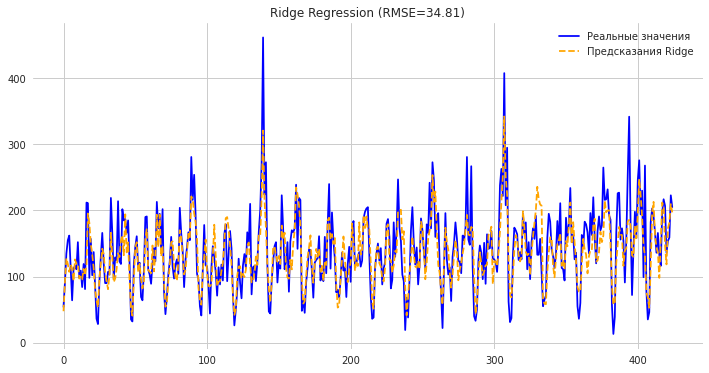

In [27]:
# визуализируем реальные и предсказанные значения

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Реальные значения', color='blue')
plt.plot(y_pred, label='Предсказания Ridge', color='orange', linestyle='--')
plt.legend()
plt.title(f"Ridge Regression (RMSE={test_rmse:.2f})")
plt.show()

In [30]:
#проверка на адекватность
# Создаем наивный прогноз: "следующее значение = предыдущее"
naive_pred = y_test.shift(1)
naive_pred.iloc[0] = y_train.iloc[-1]  # Первое значение = последнее из трейна

# Считаем RMSE для наивной модели
naive_rmse = mean_squared_error(y_test, naive_pred, squared=False)
print(f"Наивный прогноз RMSE: {naive_rmse:.2f}")
print(f"Ridge RMSE: {test_rmse:.2f}")

Наивный прогноз RMSE: 58.82
Ridge RMSE: 34.81


### Вывод по обучению моделей:

Для предсказания количества заказов на следующий час мы использовали три модели: Ridge Regression, Random Forest, CatBoostRegressor. Все модели показали удовлетворительный результат на тренировочной выборке. Модель, которая показала лучшеe RMSE на тренировочной и тестовой выборке - Ridge Regression с показателем RMSE = 34.81.

## Общий вывод по работе

### Анализ данных и признаки
* Тренд: Количество заказов растёт со временем (особенно в вечерние и ночные часы).

- Сезонность:

    - В будни: Пики вечером (18:00–23:00).

    - В выходные: Пики в воскресенье вечером, но общее число заказов меньше, чем в пятницу/субботу.

- Аномалии: Резкие всплески в праздники (например, 2–3 марта).

- Признаки:

    - Лаги (lag_(1-24), lag_168) + час/день недели уловили базовый тренд.
    
Для предсказания количества заказов на следующий час мы использовали три модели. Все показали удовлетворительные результаты с RMSE 23, 24 и 27 для Ridge, Random Forest и CatBoostRegression соответственно. Преимущество Ridge в данной задачи заключается, вероятно, в сильной линейной зависимости от лагов, в то время как, бустинг и случайный лес переобучаются на шум. На тестовой выборке Ridge показала также удовлетворительный результат с RMSE=34.81